In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
import seaborn as sns

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

# GM

In [3]:
#you can also query like this
blaze_gm_data = pd.read_sql_query("""
with base as 
(
   select
      *,
      last_day(week_start) year_month,
      retail_value / quantity_sold per_unit_price,
      cogs / quantity_sold per_unit_cost,
      sales.retail_value - sales.total_discount + sales.total_tax sales_post_tax_post_discount,
      sales.retail_value - sales.total_discount sales_pre_tax_post_discount,
      sales.retail_value sales_pre_tax_pre_discount,
   from
      blaze_data.sales sales
      -- EXCLUDE SAMPLES,DISPLAY,PROMO and test
   where
      lower(product_category) not like '%sample%' 
      and lower(product_category) not like '%display%' 
      and lower(product_category) not like '%promo%' 
      and lower(product_category) not like '%test%'
      and state = 'CA'
)
,
monthly_location_rev_and_cogs as 
(
   select
      year_month,
      shop_id shopid,
      company_id companyid,
      sum(sales_post_tax_post_discount) rev_post_tax_post_discount,
      sum(sales_pre_tax_post_discount) rev_pre_tax_post_discount,
      sum(sales_pre_tax_pre_discount) rev_pre_tax_pre_discount,
      sum(cogs) cogs 
   from
      base
      -- EXCLUDE low COGS items
   where
      cogs > 1 
      -- EXCLUDE high cost, high price items
      and per_unit_price <= 500 
      and per_unit_cost <= 500 
   group by
      2,
      3,
      1 
   order by
      2,
      3,
      1 
)
,
monthly_location_rev_and_cogs_and_profit as 
(
   select
      year_month,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      rev_post_tax_post_discount - cogs profit_post_tax_post_discount,
      rev_pre_tax_post_discount - cogs profit_pre_tax_post_discount,
      rev_pre_tax_pre_discount - cogs profit_pre_tax_pre_discount,
   from
      monthly_location_rev_and_cogs 
)
,
monthly_location_rev_and_cogs_and_profit_and_margin as 
(
   select
      year_month,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      profit_post_tax_post_discount,
      profit_pre_tax_post_discount,
      profit_pre_tax_pre_discount,
      -- margin
      profit_post_tax_post_discount / nullif(rev_post_tax_post_discount, 0) margin_post_tax_post_discount,
      profit_pre_tax_post_discount / nullif(rev_pre_tax_post_discount, 0) margin_pre_tax_post_discount,
      profit_pre_tax_pre_discount / nullif(rev_pre_tax_pre_discount, 0) margin_pre_tax_pre_discount 
   from
      monthly_location_rev_and_cogs_and_profit 
)
,
monthly_gm_analysis as 
(
   select
      year_month,
      shopid,
      companyid,
      -- CHOOSE TO USE PRE TAX POST DISCOUNT
      rev_pre_tax_post_discount,
      lag(rev_pre_tax_post_discount) over (partition by shopid order by year_month) lag_rev_pre_tax_post_discount,
      cogs,
      profit_pre_tax_post_discount,
      margin_pre_tax_post_discount,
      count(distinct year_month) over (partition by shopid ) month_available,
      sum(cogs) over (partition by shopid order by year_month rows between 2 preceding and current row ) sum_cogs_3m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month rows between 2 preceding and current row ) avg_margin_3m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month rows between 5 preceding and current row ) avg_margin_6m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month ) avg_margin_all 
   from
      monthly_location_rev_and_cogs_and_profit_and_margin 
)
select
   *,
   (
      rev_pre_tax_post_discount - lag_rev_pre_tax_post_discount
   )
   / nullif(lag_rev_pre_tax_post_discount, 0) rev_change 
from
   monthly_gm_analysis
   where shopid not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                        "6226640755810d3311e8ecd0")
""",engine)

In [4]:
blaze_gm_data['year_month'] = pd.to_datetime(blaze_gm_data['year_month'])

In [5]:
blaze_gm_data['shopid'].nunique()

355

In [6]:
blaze_gm_data[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,234
2021-09-30,246
2021-10-31,258
2021-11-30,257
2021-12-31,267
2022-01-31,263
2022-02-28,264
2022-03-31,273
2022-04-30,268


In [7]:
blaze_gm_data_long = blaze_gm_data[blaze_gm_data['month_available'] >= 6]

In [8]:
blaze_gm_data_long[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,205
2021-09-30,215
2021-10-31,224
2021-11-30,238
2021-12-31,250
2022-01-31,259
2022-02-28,259
2022-03-31,257
2022-04-30,252


In [9]:
blaze_gm_data_long[blaze_gm_data_long['year_month'] == '2022-07-31'][['shopid','month_available']].groupby(['month_available']).nunique()



,shopid
month_available,
6,5
7,10
8,15
9,11
10,12
11,13
12,166


## MoM margin

In [10]:
# mom margin
gm_distr_mom = blaze_gm_data_long.groupby(['year_month'])['margin_pre_tax_post_discount'].describe().reset_index()
gm_distr_mom.index = pd.to_datetime(gm_distr_mom['year_month'])
gm_distr_mom

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,205.0,0.511605,0.218429,-1.844289,0.465585,0.524896,0.589046,0.985539
2021-09-30,2021-09-30,215.0,0.505299,0.336270,-3.842419,0.475797,0.533547,0.592502,0.985197
2021-10-31,2021-10-31,224.0,0.271706,3.648457,-54.000000,0.469255,0.527275,0.592124,0.989650
2021-11-30,2021-11-30,238.0,0.522833,0.157688,-0.957678,0.463891,0.525527,0.589763,0.991827
2021-12-31,2021-12-31,250.0,0.532667,0.126632,-0.177532,0.470603,0.531568,0.597612,0.989949
2022-01-31,2022-01-31,259.0,0.534122,0.127470,-0.206337,0.481402,0.533879,0.600622,0.993993
2022-02-28,2022-02-28,259.0,0.510511,0.297261,-3.669029,0.471112,0.538040,0.593090,0.990898
2022-03-31,2022-03-31,257.0,0.527700,0.156914,-1.143141,0.472950,0.541442,0.596538,0.980181
2022-04-30,2022-04-30,252.0,0.521607,0.156184,-0.726965,0.470480,0.539215,0.591612,0.921176


In [11]:
round(gm_distr_mom[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.54
75%    0.59
dtype: float64

In [12]:
round(blaze_gm_data_long['margin_pre_tax_post_discount'].quantile(0.95),2)

0.7

## 3m

In [13]:
gm_distr_3m = blaze_gm_data_long.groupby(['year_month'])['avg_margin_3m'].describe().reset_index()
gm_distr_3m.index = pd.to_datetime(gm_distr_3m['year_month'])
gm_distr_3m

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,205.0,0.511605,0.218429,-1.844289,0.465585,0.524896,0.589046,0.985539
2021-09-30,2021-09-30,215.0,0.510388,0.255003,-2.181210,0.474063,0.525360,0.589388,0.985368
2021-10-31,2021-10-31,224.0,0.275475,3.647304,-54.000000,0.472501,0.525498,0.588284,0.986795
2021-11-30,2021-11-30,238.0,0.512150,0.207831,-1.422507,0.470582,0.525204,0.589068,0.988891
2021-12-31,2021-12-31,250.0,0.519524,0.188924,-1.266981,0.470570,0.529634,0.584334,0.990475
2022-01-31,2022-01-31,259.0,0.424300,1.697033,-26.697390,0.467442,0.529378,0.591352,0.991923
2022-02-28,2022-02-28,259.0,0.454182,1.136982,-17.603180,0.468614,0.533213,0.593576,0.991613
2022-03-31,2022-03-31,257.0,0.523295,0.162019,-0.929169,0.467100,0.536173,0.591402,0.988357
2022-04-30,2022-04-30,252.0,0.519967,0.165840,-0.817287,0.469905,0.535171,0.592748,0.934692


In [14]:
round(gm_distr_3m[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [15]:
round(blaze_gm_data_long['avg_margin_3m'].quantile(0.95),2)

0.69

## 6m

In [16]:
gm_distr_6m = blaze_gm_data_long.groupby(['year_month'])['avg_margin_6m'].describe().reset_index()
gm_distr_6m.index = pd.to_datetime(gm_distr_6m['year_month'])
gm_distr_6m

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,205.0,0.511605,0.218429,-1.844289,0.465585,0.524896,0.589046,0.985539
2021-09-30,2021-09-30,215.0,0.510388,0.255003,-2.181210,0.474063,0.525360,0.589388,0.985368
2021-10-31,2021-10-31,224.0,0.275475,3.647304,-54.000000,0.472501,0.525498,0.588284,0.986795
2021-11-30,2021-11-30,238.0,0.511527,0.211880,-1.422507,0.471066,0.523453,0.586111,0.988053
2021-12-31,2021-12-31,250.0,0.517964,0.185770,-1.118417,0.473952,0.525561,0.583286,0.988432
2022-01-31,2022-01-31,259.0,0.414570,1.699837,-26.697390,0.469202,0.527803,0.587293,0.989359
2022-02-28,2022-02-28,259.0,0.447731,1.137646,-17.603180,0.468393,0.528806,0.588503,0.990252
2022-03-31,2022-03-31,257.0,0.467624,0.863638,-13.096554,0.464983,0.529887,0.589329,0.989416
2022-04-30,2022-04-30,252.0,0.480836,0.701224,-10.386766,0.468322,0.531679,0.591130,0.958570


In [17]:
round(gm_distr_6m[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [18]:
round(blaze_gm_data_long['avg_margin_6m'].quantile(0.95),2)

0.69

## all time

In [19]:
gm_distr_all = blaze_gm_data_long.groupby(['year_month'])['avg_margin_all'].describe().reset_index()
gm_distr_all.index = pd.to_datetime(gm_distr_all['year_month'])
round(gm_distr_all,3)

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,205.0,0.512,0.218,-1.844,0.466,0.525,0.589,0.986
2021-09-30,2021-09-30,215.0,0.510,0.255,-2.181,0.474,0.525,0.589,0.985
2021-10-31,2021-10-31,224.0,0.275,3.647,-54.000,0.473,0.525,0.588,0.987
2021-11-30,2021-11-30,238.0,0.512,0.212,-1.423,0.471,0.523,0.586,0.988
2021-12-31,2021-12-31,250.0,0.518,0.186,-1.118,0.474,0.526,0.583,0.988
2022-01-31,2022-01-31,259.0,0.415,1.700,-26.697,0.469,0.528,0.587,0.989
2022-02-28,2022-02-28,259.0,0.446,1.138,-17.603,0.471,0.528,0.588,0.990
2022-03-31,2022-03-31,257.0,0.465,0.864,-13.097,0.467,0.529,0.588,0.988
2022-04-30,2022-04-30,252.0,0.476,0.704,-10.387,0.468,0.530,0.589,0.968


In [20]:
round(gm_distr_all[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [21]:
round(blaze_gm_data_long['avg_margin_all'].quantile(0.95),2)

0.68

# Rev change

In [22]:
def gmv_change_variance_point_mapping(x):
    if x < -0.1:
        return -5
    elif x >= -0.1 and x <-0.05:
        return -2.5
    elif x >= -0.05 and x < 0:
        return 0
    elif x >= 0 and x < 0.05:
        return 5
    elif x >= 0.05 and x <= 0.5:
        return 10
    else:
        return numpy.nan
    

In [23]:
rev_change_bm = blaze_gm_data_long.groupby(['year_month'])['rev_change'].describe().reset_index()
rev_change_bm.index = pd.to_datetime(rev_change_bm['year_month'])
rev_change_bm

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,2021-09-30,203.0,3.868787,46.885117,-0.583663,0.136069,0.203086,0.279863,667.214941
2021-10-31,2021-10-31,213.0,2.621434,27.324544,-0.865051,-0.022154,0.026652,0.086844,394.366300
2021-11-30,2021-11-30,225.0,6.890835,83.511109,-0.879068,-0.121120,-0.055503,0.006603,1221.495722
2021-12-31,2021-12-31,235.0,0.462674,2.899744,-0.825981,-0.009764,0.055012,0.134821,34.464060
2022-01-31,2022-01-31,250.0,125.934257,1647.683025,-0.942798,-0.113392,-0.057280,0.000616,25358.430000
2022-02-28,2022-02-28,256.0,6.336095,90.942619,-0.904537,-0.115461,-0.055561,0.020240,1448.165000
2022-03-31,2022-03-31,257.0,1.418427,19.765321,-0.999341,0.033264,0.102386,0.169690,316.685389
2022-04-30,2022-04-30,252.0,6.549461,102.584571,-0.950140,-0.052878,0.004560,0.082419,1628.531706


In [24]:
#you can also query like this
blaze_ca_gmv_change_data = pd.read_sql_query("""
---------------------------------------------------------------------------------------------------------------------
with base as
(
   select
      shop_id,
      company_id,
      last_day(week_start) year_month,
      sales.retail_value - sales.total_discount sales_pre_tax_post_discount
   from
      blaze_data.sales sales

   where
      lower(product_category) not like '%sample%'
      and lower(product_category) not like '%display%'
      and lower(product_category) not like '%promo%'
      and lower(product_category) not like '%test%'
      and state = 'CA'
      and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
)
,
monthly_rev as
(
   select
      year_month,
      sum(sales_pre_tax_post_discount) rev_pre_tax_post_discount,
      count(distinct shop_id) count_shop
   from
      base
   group by
1
),

monthly_rev_with_lag as
(
   select
      year_month,
      rev_pre_tax_post_discount,
      count_shop,
      lag(rev_pre_tax_post_discount) over (order by year_month) lag_rev_pre_tax_post_discount,
      lag(count_shop) over (order by year_month) lag_count_shop
   from
      monthly_rev
)
select
   *,
    rev_pre_tax_post_discount / count_shop rev_per_shop,
       lag_rev_pre_tax_post_discount / lag_count_shop lag_rev_per_shop,
   (
      rev_pre_tax_post_discount / count_shop - lag_rev_pre_tax_post_discount / lag_count_shop
   )
   / nullif(lag_rev_pre_tax_post_discount / lag_count_shop, 0) rev_change
from
   monthly_rev_with_lag
order by year_month
""",engine)

In [25]:
blaze_ca_gmv_change_data['year_month'] = pd.to_datetime(blaze_ca_gmv_change_data['year_month'])

<AxesSubplot:>

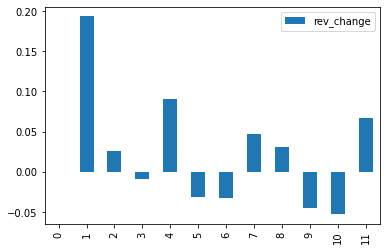

In [26]:
blaze_ca_gmv_change_data[['rev_change']].plot(kind = 'bar')

In [27]:
blaze_ca_gmv_change_data

,year_month,rev_pre_tax_post_discount,count_shop,lag_rev_pre_tax_post_discount,lag_count_shop,rev_per_shop,lag_rev_per_shop,rev_change
0,2021-08-31,50497792.04,235,NaN,NaN,214884.221447,NaN,NaN
1,2021-09-30,63594461.53,248,50497792.04,235.0,256429.280363,214884.221447,0.193337
2,2021-10-31,68648659.92,261,63594461.53,248.0,263021.685517,256429.280363,0.025708
3,2021-11-30,68272899.90,262,68648659.92,261.0,260583.587405,263021.685517,-0.009270
4,2021-12-31,76714104.42,270,68272899.90,262.0,284126.312667,260583.587405,0.090346
5,2022-01-31,73239968.35,266,76714104.42,270.0,275338.226880,284126.312667,-0.030930
6,2022-02-28,70823019.42,266,73239968.35,266.0,266251.952707,275338.226880,-0.033000
7,2022-03-31,76344594.37,274,70823019.42,266.0,278629.906460,266251.952707,0.046490
8,2022-04-30,77274601.90,269,76344594.37,274.0,287266.178067,278629.906460,0.030995
9,2022-05-31,73785464.44,269,77274601.90,269.0,274295.406840,287266.178067,-0.045152


In [28]:
rev_change_bm_with_weight = blaze_ca_gmv_change_data[['year_month','rev_change']]
rev_change_bm_with_weight['weight'] = [numpy.nan,0.2,0.28,0.36,0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]
rev_change_bm_with_weight.columns = ['year_month','rev_change_bm','rev_change_weight']
rev_change_bm_with_weight = rev_change_bm_with_weight.reset_index(drop = True)
rev_change_bm_with_weight

,year_month,rev_change_bm,rev_change_weight
0,2021-08-31,NaN,NaN
1,2021-09-30,0.193337,0.20
2,2021-10-31,0.025708,0.28
3,2021-11-30,-0.009270,0.36
4,2021-12-31,0.090346,0.44
5,2022-01-31,-0.030930,0.52
6,2022-02-28,-0.033000,0.60
7,2022-03-31,0.046490,0.68
8,2022-04-30,0.030995,0.76
9,2022-05-31,-0.045152,0.84


In [29]:

blaze_gm_data_long_with_rev  = pd.merge(blaze_gm_data_long,rev_change_bm_with_weight,on=['year_month'], how='inner')
blaze_gm_data_long_with_rev['rev_change_var'] = blaze_gm_data_long_with_rev['rev_change'] - blaze_gm_data_long_with_rev['rev_change_bm']
blaze_gm_data_long_with_rev['rev_change_points'] = [gmv_change_variance_point_mapping(n) for n in blaze_gm_data_long_with_rev['rev_change_var']]
blaze_gm_data_long_with_rev['rev_change_total'] = blaze_gm_data_long_with_rev['rev_change_points'] * blaze_gm_data_long_with_rev['rev_change_weight']



In [30]:
blaze_gm_data_long_with_rev.tail()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total
2882,2021-10-31,6046f5d9b30b4e08e7f95064,6046f5d9b30b4e08e7f9504a,170316.47,187816.92,75884.54,94431.93,0.554450,7,224614.86,0.560132,0.560132,0.560132,-0.093178,0.025708,0.28,-0.118887,-5.0,-1.4
2883,2021-10-31,5e21f409c6837e0858e8eaba,5e21f409c6837e0858e8eaa2,183641.43,180293.87,82327.79,101313.64,0.551693,12,234738.53,0.557089,0.557089,0.557089,0.018567,0.025708,0.28,-0.007141,0.0,0.0
2884,2021-10-31,5f3df0a5ef56f908dd5b372c,5f3df0a5ef56f908dd5b3714,96532.85,97331.30,41608.73,54924.12,0.568968,12,118263.15,0.541530,0.541530,0.541530,-0.008203,0.025708,0.28,-0.033912,0.0,0.0
2885,2021-10-31,5ca5725ee8379e080ae7cb62,5ca5725ee8379e080ae7cb4b,51073.75,54749.89,27702.06,23371.69,0.457607,12,78313.37,0.488962,0.488962,0.488962,-0.067144,0.025708,0.28,-0.092853,-2.5,-0.7
2886,2021-10-31,5e336a31e0faca07f4739f38,5e336a31e0faca07f4739f1f,26189.77,6230.49,2029.75,24160.02,0.922498,9,4794.21,0.803453,0.803453,0.803453,3.203485,0.025708,0.28,3.177776,NaN,NaN


In [31]:

blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['shopid'] == '5c8844b3e0faca07c1ec05ec']

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total
102,2021-11-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,799813.40,874794.41,435482.40,364331.00,0.455520,12,1543444.26,0.439574,0.430901,0.430901,-0.085713,-0.009270,0.36,-0.076443,-2.5,-0.9
346,2021-12-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,815112.94,799813.40,423726.90,391386.04,0.480162,12,1355469.65,0.456131,0.440753,0.440753,0.019129,0.090346,0.44,-0.071217,-2.5,-1.1
601,2022-01-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,737587.91,815112.94,385753.63,351834.28,0.477007,12,1244962.93,0.470896,0.446795,0.446795,-0.095110,-0.030930,0.52,-0.064179,-2.5,-1.3
859,2022-02-28,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,657149.87,737587.91,382556.02,274593.85,0.417856,12,1192036.55,0.458341,0.448958,0.442661,-0.109056,-0.033000,0.60,-0.076055,-2.5,-1.5
1116,2022-03-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,634752.77,657149.87,350415.64,284337.13,0.447949,12,1118725.29,0.447604,0.451868,0.443322,-0.034082,0.046490,0.68,-0.080572,-2.5,-1.7
1371,2022-04-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,760663.70,634752.77,423784.99,336878.71,0.442875,12,1156756.65,0.436227,0.453561,0.443272,0.198362,0.030995,0.76,0.167367,10.0,7.6
1626,2022-05-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,720045.86,760663.70,369307.65,350738.21,0.487105,12,1143508.28,0.459310,0.458826,0.447656,-0.053398,-0.045152,0.84,-0.008245,0.0,0.0
1875,2022-06-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,594681.01,720045.86,304703.55,289977.46,0.487618,12,1097796.19,0.472533,0.460068,0.451289,-0.174107,-0.052679,0.92,-0.121428,-5.0,-4.6
2113,2022-07-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,595956.45,594681.01,299331.79,296624.66,0.497729,12,973342.99,0.490818,0.463522,0.455159,0.002145,0.066443,1.00,-0.064299,-2.5,-2.5
2324,2021-08-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,1074097.89,NaN,639216.32,434881.57,0.404881,12,639216.32,0.404881,0.404881,0.404881,NaN,NaN,NaN,NaN,NaN,NaN


# inventory

In [ ]:
blaze_inv_data_snap = pd.read_sql_query("""
with base as (
    select *,
    last_day(date) year_month,
    current_quantity * unit_cost total_value
    from blaze_data.inventory
    where  lower(product_category) not like '%sample%'
    and lower(product_category) not like '%display%'
    and lower(product_category) not like '%promo%'
    and lower(product_category) not like '%test%'
    -- EXCLUDE SMALL COGS
    and unit_cost > 0.01
    and current_quantity > 0
    and current_quantity < 1000
    and date in ('2022-04-24')
    and state = 'CA'
    and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
)

select
year_month,
shop_id shopid,
company_id companyid,
sum(total_value) inventory
from base
group by 1,2,3
order by 2,3,1


""",engine)

In [32]:
blaze_inv_data = pd.read_sql_query("""
with base as (
    select *,
    --last_day(date) year_month,
    current_quantity * unit_cost total_value
    from blaze_data.inventory
    where  lower(product_category) not like '%sample%'
    and lower(product_category) not like '%display%'
    and lower(product_category) not like '%promo%'
    and lower(product_category) not like '%test%'
    -- EXCLUDE SMALL COGS
    and unit_cost > 0.01
    and current_quantity > 0
    and current_quantity < 1000
    and date in ('2022-07-01','2022-07-04','2022-07-11','2022-07-18','2022-07-25')

    and state = 'CA'
    and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
),
weekly_inv as (
    select date,
           shop_id          shopid,
           company_id       companyid,
           sum(total_value) inventory
    from base
    group by 1, 2, 3
    order by 2, 3, 1
)
select
shopid,
companyid,
avg(inventory) inventory,
last_day('2022-07-24') year_month
from weekly_inv
group by 1,2
""",engine)

In [33]:
blaze_inv_data['year_month'] = pd.to_datetime(blaze_inv_data['year_month'])

In [34]:
blaze_inv_data['shopid'].nunique()

390

In [35]:
blaze_inv_data

,shopid,companyid,inventory,year_month
0,5b256a8eff7e6b08094adb42,5b1dbdf3cf43c1080b198e70,278275.209333,2022-07-31
1,5b6496ccebb2320839409957,5b6496ccebb2320839409941,281716.270000,2022-07-31
2,5bc69443d505bf082cc7cadf,5bc69443d505bf082cc7cac8,350566.066000,2022-07-31
3,5c7e8c7b722ed607e61edb1d,5c7e8c7b722ed607e61edb06,87901.608000,2022-07-31
4,5c918305db9f6307fc071b15,5c918305db9f6307fc071afe,11683.708000,2022-07-31
...,...,...,...,...
385,622f7cdbe4d01b449434b320,5ae108e5687ddd6db07e0ec5,43845.210000,2022-07-31
386,625dfafd25118d7f87c24c69,625dfafd25118d7f87c24c4e,18822.050000,2022-07-31
387,5f3c49beecfd2508eeec270c,5e0e38b8c2e7da08240065e4,1858.940000,2022-07-31
388,5fd1441f4a81c508e62179e4,5fd1441f4a81c508e62179cc,2261.140000,2022-07-31


In [36]:
set(blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['year_month'] == '2022-07-31']['shopid']) - set(blaze_inv_data['shopid'])

set()

# joined

In [37]:
data_joined = pd.merge(blaze_gm_data_long_with_rev,blaze_inv_data,on=['year_month','shopid','companyid'], how='inner')



In [38]:
data_joined['inventory_turnover'] = data_joined['sum_cogs_3m'] / data_joined['inventory'] * 4
data_joined['year_month'] = pd.to_datetime(data_joined['year_month'])

In [39]:
data_joined[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2022-07-31,232


In [40]:
data_joined[data_joined['year_month'] >= '2021-10-31'].groupby(['year_month'])['inventory_turnover'].describe().reset_index()

,year_month,count,mean,std,min,25%,50%,75%,max
0,2022-07-31,232.0,9.207191,6.008512,0.004797,4.996415,7.671359,13.119488,30.137936


In [41]:
round(data_joined['inventory_turnover'].quantile(0.95),2)

19.92

# Vendor Churn

In [42]:
blaze_vc_data = pd.read_sql_query("""
-- purcase order data
with date as (
    SELECT last_day(year_month) year_month_all
FROM UNNEST(
    GENERATE_DATE_ARRAY(DATE('2021-08-01'), CURRENT_DATE(), INTERVAL 1 month)
) AS year_month
),
vendor as (
    select distinct vendor_id from blaze_data.purchase_orders
),
shop as (
    select distinct shop_id from blaze_data.purchase_orders
    where state = 'CA'
    and purchase_order_status = 'Closed'
    and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
),
all_data as (
    with sub as (
        select *
        from date
                 cross join vendor
    )
    select * from sub cross join shop
),
po_clean as (select * 
from  (
select DATE_DIFF(week_end, week_start, DAY) diff,* from blaze_data.purchase_orders
             WHERE not (week_start = '2022-01-29' and week_end = '2022-02-05')
and not (week_start = '2022-02-26' and week_end = '2022-03-05')
and not (week_start = '2022-03-27' and week_end = '2022-04-03'))
     where diff < 10)
     ,
po_data as (
    select last_day(week_start) year_month,
           shop_id,
           vendor_id,
           sum(total_cost)      total_amount

    from po_clean
    group by 1, 2, 3
),

vc_data as (
    select all_data.year_month_all,
           all_data.vendor_id,
           all_data.shop_id,
           COALESCE(po_data.total_amount, 0) amount,
           sum(po_data.total_amount) over (partition by all_data.shop_id,all_data.vendor_id) facility_total,
           sum(po_data.total_amount) over (partition by all_data.shop_id) all_vendor_total,
           sum(po_data.total_amount) over (partition by all_data.shop_id,all_data.vendor_id order by all_data.year_month_all rows between 3 preceding and current row) last_4m_total
           --lag( COALESCE(po_data.total_amount,0)) over (partition by all_data.vendor_id,all_data.shop_id order by year_month_all) lag_total_amount,

    from all_data
             left join po_data
                       on all_data.year_month_all = po_data.year_month
                           and all_data.vendor_id = po_data.vendor_id
                           and all_data.shop_id = po_data.shop_id
),

vc_data_weight as (
    select year_month_all,
           vendor_id,
           shop_id,
           amount,
           COALESCE(facility_total, 0)  vendor_total,
           COALESCE(all_vendor_total, 0) all_vendor_total,
           COALESCE(last_4m_total, 0) last_4m_total
    from vc_data
),
vc_data_weight_clean as (
    select
    year_month_all,
    vendor_id,
    shop_id,
    amount,
    vendor_total,
    all_vendor_total,
    last_4m_total,
    vendor_total / NULLIF(all_vendor_total, 0)  vendor_perc,
    case when last_4m_total = 0 then '4m_inactive' else '4m_active' end as activity,
    case
    when  vendor_total/ NULLIF(all_vendor_total, 0) > 0.001 then 'significant'
    else 'non-significant' end as significance
    from vc_data_weight
),
/* for debug
     select * from vc_data_weight_clean
                where shop_id = '5f0d3e91aa5bca08d2438446'
                and significance = 'significant'

 */

vc_final as (
    select
    *,
    case when activity = '4m_active' and significance = 'significant' then 'active'
    else (case when significance = 'significant' then 'inactive' else 'exclude' end) end as measure
    from vc_data_weight_clean
    )


select
shop_id shopid,
sum(vendor_perc) total_vc
from vc_final
where year_month_all = '2022-07-31'
and measure = 'inactive'
group by 1

""",engine)

In [43]:
blaze_vc_data

,shopid,total_vc
0,5d40d66f4c431007fe6ab25c,0.043163
1,5fa0bc93efe39d08dd3c0c7c,0.146514
2,5b3c218fffa6000829938a00,0.200478
3,5dcc5cefa859fd08300189f1,0.049383
4,5ca5725ee8379e080ae7cb62,0.245806
...,...,...
261,61fc763a4891105ae4b98705,0.009580
262,616a3e1b5c4d401446b0eb19,0.107170
263,60db6f726f5cb172401c925e,0.008286
264,614136b3a2c111601c195a59,1.000000


In [44]:
data_joined_with_vc = data_joined.merge(blaze_vc_data,on = 'shopid',how = 'left')

In [45]:
data_joined_with_vc['total_vc'].describe()

count    192.000000
mean       0.202690
std        0.259854
min        0.001444
25%        0.057958
50%        0.096272
75%        0.214791
max        1.000000
Name: total_vc, dtype: float64

In [46]:
data_joined_with_vc = data_joined_with_vc.fillna(0)

In [47]:
data_joined_with_vc[data_joined_with_vc['total_vc'] == 0].shape

(40, 22)

# UW

In [48]:
recent = data_joined_with_vc[data_joined_with_vc['year_month'] == '2022-07-31']
recent = recent.reset_index(drop = True)

In [49]:
recent[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2022-07-31,232


## gm % score

In [50]:
def get_gm_perc_scores(threshold,gm_3,gm_6,gm_all):
    # 3m score
    if gm_3 <= threshold[0][0]:
        score_3m = -2
    elif threshold[0][0] < gm_3 <= threshold[0][1]:
        score_3m = 0
    elif threshold[0][1] < gm_3 <= threshold[0][2]:
        score_3m = 5
    elif threshold[0][2] < gm_3 <= threshold[0][3]:
        score_3m = 5
    else:
        score_3m = 0
    # 6m score
    if gm_6 <= threshold[1][0]:
        score_6m = -2
    elif threshold[1][0] < gm_6 <= threshold[1][1]:
        score_6m = 0
    elif threshold[1][1] < gm_6 <= threshold[1][2]:
        score_6m = 5
    elif threshold[1][2] < gm_6 <= threshold[1][3]:
        score_6m = 5
    else:
        score_6m = 0
    # all time score
    if gm_all <= threshold[2][0]:
        score_all = -2
    elif threshold[2][0] < gm_all <= threshold[2][1]:
        score_all = 0
    elif threshold[2][1] < gm_all <= threshold[2][2]:
        score_all = 5
    elif threshold[2][2] < gm_all <= threshold[2][3]:
        score_all = 5
    else:
        score_all = 0
    return score_3m,score_6m,score_all
    

In [51]:
#gm_threshold = [[0.47,0.53,0.59,0.7],[0.47,0.53,0.59,0.7],[0.47,0.53,0.59,0.7]]

In [ ]:
#gm_threshold = [[0.46,0.52,0.58,0.7],[0.46,0.52,0.58,0.7],[0.46,0.52,0.58,0.7]]

In [ ]:
#gm_threshold = [[0.45,0.51,0.57,0.7],[0.45,0.51,0.57,0.7],[0.45,0.51,0.57,0.7]]

In [52]:
gm_threshold = [[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7]]

In [53]:
gm_score_data = recent.apply(lambda row: get_gm_perc_scores(gm_threshold,row['avg_margin_3m'],row['avg_margin_6m'],row['avg_margin_all']),axis = 1)
recent_with_gm = pd.concat([recent, pd.DataFrame([list(y) for y in gm_score_data.values], columns = ['gm_3m_score', 'gm_6m_score','gm_all_score'])],axis=1)



## inventory turnover score

In [54]:
recent_with_gm['turnover_score'] = [10 if (recent_with_gm['inventory_turnover'][i] >= 6 and recent_with_gm['inventory_turnover'][i] <= 26) else 0 for i in range(len(recent_with_gm))]



In [55]:
recent_with_gm.head()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score
0,2022-07-31,6195ba64b2153b6d9fe20521,5e8b520200aa8008dee7e479,265420.34,252589.66,112450.44,152969.90,0.576331,9,346496.64,0.567344,0.564745,0.549097,0.050797,0.066443,1.0,-0.015647,0.0,0.0,182671.666,7.587310,0.000000,5,5,5,10
1,2022-07-31,6195ba56eb17b71a008e3c38,5e8b520200aa8008dee7e479,827592.68,828822.85,374092.37,453500.31,0.547975,8,1148547.57,0.539890,0.532388,0.531991,-0.001484,0.066443,1.0,-0.067928,-2.5,-2.5,532298.693,8.630850,0.111000,5,5,5,10
2,2022-07-31,5d3f6a2ebc0f3d07fbca02ba,5d3f6a2ebc0f3d07fbca02a3,160697.44,171121.00,48644.25,112053.19,0.697293,12,150321.58,0.711743,0.722803,0.692021,-0.060913,0.066443,1.0,-0.127357,-5.0,-5.0,89213.072,6.739890,0.238525,0,0,5,10
3,2022-07-31,5f77e2203bf44f09144759c1,5ebb25915a7c1308eda55413,293591.46,305852.14,121643.08,171948.38,0.585672,12,389897.00,0.579753,0.567178,0.519452,-0.040087,0.066443,1.0,-0.106530,-5.0,-5.0,113380.801,13.755309,0.077818,5,5,5,10
4,2022-07-31,5faace3070324e08cdd31fa0,5faace3070324e08cdd31f88,129696.46,129846.36,42020.82,87675.64,0.676006,12,126808.85,0.675877,0.660327,0.639680,-0.001154,0.066443,1.0,-0.067598,-2.5,-2.5,124238.342,4.082761,0.247014,5,5,5,0


## rev change score

In [56]:
rev_change_score = blaze_gm_data_long_with_rev[['shopid','rev_change_total']].groupby('shopid').sum().reset_index()

In [57]:
rev_change_score['rev_change_score'] = [max(min(round(rev_change_score['rev_change_total'][i],2),10),-10) for i in range(len(rev_change_score))]
rev_change_score.sort_values(by = 'rev_change_total')


,shopid,rev_change_total,rev_change_score
152,5fcff3a874329008ef2b4112,-31.3,-10.0
201,60d376c7638c221fab13422c,-23.4,-10.0
125,5f18c6e85c031a08e19861c2,-23.0,-10.0
78,5e1cc22ca3b04d084c46b543,-21.6,-10.0
14,5ba96aac00635e08245eb7c7,-21.2,-10.0
...,...,...,...
226,6132533ac57eb479d9a85663,39.0,10.0
219,611a8a33c4acc3573cd299e8,39.0,10.0
141,5f99beff00fecc08ddc55c60,40.5,10.0
188,60a2d2a51775b12de7610240,48.2,10.0


## gm $ score

In [58]:
gm_dollar_score = blaze_gm_data_long_with_rev[['shopid','profit_pre_tax_post_discount']].groupby('shopid').mean().reset_index()

In [59]:
gm_dollar_score['gm_dollar_score'] = [15 if gm_dollar_score['profit_pre_tax_post_discount'][i] >= 200000 else 0 for i in range(len(rev_change_score))]



In [60]:
recent_with_gm_and_rev_change = pd.merge(recent_with_gm,rev_change_score[['shopid','rev_change_score']],on=['shopid'], how='inner')
recent_with_gm_and_rev_change

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score
0,2022-07-31,6195ba64b2153b6d9fe20521,5e8b520200aa8008dee7e479,265420.34,252589.66,112450.44,152969.90,0.576331,9,346496.64,0.567344,0.564745,0.549097,0.050797,0.066443,1.0,-0.015647,0.0,0.0,182671.666000,7.587310,0.000000,5,5,5,10,7.6
1,2022-07-31,6195ba56eb17b71a008e3c38,5e8b520200aa8008dee7e479,827592.68,828822.85,374092.37,453500.31,0.547975,8,1148547.57,0.539890,0.532388,0.531991,-0.001484,0.066443,1.0,-0.067928,-2.5,-2.5,532298.693000,8.630850,0.111000,5,5,5,10,9.0
2,2022-07-31,5d3f6a2ebc0f3d07fbca02ba,5d3f6a2ebc0f3d07fbca02a3,160697.44,171121.00,48644.25,112053.19,0.697293,12,150321.58,0.711743,0.722803,0.692021,-0.060913,0.066443,1.0,-0.127357,-5.0,-5.0,89213.072000,6.739890,0.238525,0,0,5,10,-0.4
3,2022-07-31,5f77e2203bf44f09144759c1,5ebb25915a7c1308eda55413,293591.46,305852.14,121643.08,171948.38,0.585672,12,389897.00,0.579753,0.567178,0.519452,-0.040087,0.066443,1.0,-0.106530,-5.0,-5.0,113380.801000,13.755309,0.077818,5,5,5,10,10.0
4,2022-07-31,5faace3070324e08cdd31fa0,5faace3070324e08cdd31f88,129696.46,129846.36,42020.82,87675.64,0.676006,12,126808.85,0.675877,0.660327,0.639680,-0.001154,0.066443,1.0,-0.067598,-2.5,-2.5,124238.342000,4.082761,0.247014,5,5,5,0,8.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,2022-07-31,61eb3bdf4b2950266e089bb2,61eb3bdf4b2950266e089b98,53403.59,54506.50,23326.95,30076.64,0.563195,6,82304.99,0.536954,0.533057,0.533057,-0.020234,0.066443,1.0,-0.086678,-2.5,-2.5,11775.437000,27.958195,0.000000,5,5,5,0,8.9
228,2022-07-31,5ff3451006f48b08dc93dc6a,5ff3451006f48b08dc93dc52,20071.13,21413.00,7237.81,12833.32,0.639392,12,24122.78,0.614364,0.611605,0.593112,-0.062666,0.066443,1.0,-0.129110,-5.0,-5.0,18775.858000,5.139106,0.295660,5,5,5,0,10.0
229,2022-07-31,5e21f409c6837e0858e8eaba,5e21f409c6837e0858e8eaa2,119295.84,113531.00,68802.71,50493.13,0.423260,12,215433.14,0.388398,0.446257,0.504518,0.050778,0.066443,1.0,-0.015666,0.0,0.0,98214.609667,8.773975,0.000000,-2,0,5,10,-1.2
230,2022-07-31,5f3df0a5ef56f908dd5b372c,5f3df0a5ef56f908dd5b3714,27882.70,37251.43,14584.64,13298.06,0.476929,12,54404.83,0.457884,0.455416,0.484093,-0.251500,0.066443,1.0,-0.317943,-5.0,-5.0,53872.677000,4.039512,0.062720,0,0,0,0,-2.1


# VC score

In [61]:
recent_with_gm_and_rev_change['vc_score'] = [10 if recent_with_gm_and_rev_change['total_vc'][i] < 0.17 else 0 for i in range(len(recent_with_gm_and_rev_change))]



# Final

In [62]:
final = pd.merge(recent_with_gm_and_rev_change,gm_dollar_score[['shopid','gm_dollar_score']],on=['shopid'], how='inner')



In [63]:
final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score'] + final['vc_score']
final['credit_limit'] = [round(min(final['sum_cogs_3m'][i],final['inventory'][i]),0) for i in range(len(final))]
                        



In [ ]:
# final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
# final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
# final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score'] 
# final['credit_limit'] = [round(min(final['sum_cogs_3m'][i],final['inventory'][i]),0) for i in range(len(final))]
                        



In [64]:
final['total_score'].describe()

count    232.000000
mean      29.393966
std       14.077923
min      -16.000000
25%       22.750000
50%       30.000000
75%       43.525000
max       45.000000
Name: total_score, dtype: float64

In [65]:
final['shopid'].nunique()

232

In [ ]:
#final.to_csv('blaze_ca_july_all.csv')

In [66]:
pass_list = final[final['total_score'] >= 30]

In [67]:
final_pass = pass_list[(pass_list['profit_pre_tax_post_discount'] >= 25000) & (pass_list['credit_limit'] >= 30000)]
final_pass = final_pass.reset_index(drop = True)

In [68]:
final_pass['credit_limit_final'] = [min(max(final_pass['credit_limit'][i],50000),250000) for i in range(len(final_pass))]

In [69]:
def calculate_interest_rate(score, full_score):
    score_ratio = score / full_score
    placeholder = (1 + 0.5 * (1 - score_ratio)) * 0.015
    rate = placeholder * 12
    return round(placeholder, 4), round(rate, 4)

In [70]:
final_pass['annual_rate'] = [calculate_interest_rate(final_pass['total_score'][i],45)[1] for i in range(len(final_pass))]
final_pass['monthly_rate'] = [calculate_interest_rate(final_pass['total_score'][i],45)[0] for i in range(len(final_pass))]



In [71]:
final_pass.shape[0] / final.shape[0]

0.4956896551724138

In [73]:
final_pass.shape[0]

115

In [74]:
final_pass

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit,credit_limit_final,annual_rate,monthly_rate
0,2022-07-31,6195ba64b2153b6d9fe20521,5e8b520200aa8008dee7e479,265420.34,252589.66,112450.44,152969.90,0.576331,9,346496.64,0.567344,0.564745,0.549097,0.050797,0.066443,1.0,-0.015647,0.0,0.0,1.826717e+05,7.587310,0.000000,5,5,5,10,7.6,10,0,15,15,42.6,182672.0,182672.0,0.1848,0.0154
1,2022-07-31,6195ba56eb17b71a008e3c38,5e8b520200aa8008dee7e479,827592.68,828822.85,374092.37,453500.31,0.547975,8,1148547.57,0.539890,0.532388,0.531991,-0.001484,0.066443,1.0,-0.067928,-2.5,-2.5,5.322987e+05,8.630850,0.111000,5,5,5,10,9.0,10,15,15,15,44.0,532299.0,250000.0,0.1820,0.0152
2,2022-07-31,5f77e2203bf44f09144759c1,5ebb25915a7c1308eda55413,293591.46,305852.14,121643.08,171948.38,0.585672,12,389897.00,0.579753,0.567178,0.519452,-0.040087,0.066443,1.0,-0.106530,-5.0,-5.0,1.133808e+05,13.755309,0.077818,5,5,5,10,10.0,10,0,15,15,45.0,113381.0,113381.0,0.1800,0.0150
3,2022-07-31,6016fce0d9e61b08ed0e7730,6016fce0d9e61b08ed0e7718,419153.67,412450.04,218686.75,200466.92,0.478266,12,611651.20,0.514494,0.519824,0.519889,0.016253,0.066443,1.0,-0.050190,-2.5,-2.5,1.438273e+05,17.010710,0.095467,5,5,5,10,10.0,10,15,15,15,45.0,143827.0,143827.0,0.1800,0.0150
4,2022-07-31,6179efacc2a9fb671795c4f7,60edb16f8d68a874d1592862,2644402.34,2534368.83,1238440.66,1405961.68,0.531675,9,3653446.29,0.537884,0.537264,0.527763,0.043417,0.066443,1.0,-0.023027,0.0,0.0,1.010980e+06,14.455074,0.002544,5,5,5,10,10.0,10,15,15,15,45.0,1010980.0,250000.0,0.1800,0.0150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2022-07-31,611df4df750db64ca4f656b5,611df4df750db64ca4f6569c,224613.32,213613.84,95591.35,129021.97,0.574418,11,285852.39,0.571755,0.567167,0.594934,0.051492,0.066443,1.0,-0.014951,0.0,0.0,1.858693e+05,6.151685,0.093158,5,5,5,10,10.0,10,0,15,15,45.0,185869.0,185869.0,0.1800,0.0150
111,2022-07-31,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,431686.75,403826.19,192201.87,239484.88,0.554765,12,561496.49,0.555106,0.554530,0.547810,0.068991,0.066443,1.0,0.002548,5.0,5.0,2.483974e+05,9.041907,0.683159,5,5,5,10,10.0,0,15,15,15,35.0,248397.0,248397.0,0.2000,0.0167
112,2022-07-31,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,2096111.40,1949127.15,961795.53,1134315.87,0.541152,10,2770223.99,0.545496,0.543666,0.527872,0.075410,0.066443,1.0,0.008967,5.0,5.0,7.148464e+05,15.501086,0.016009,5,5,5,10,10.0,10,15,15,15,45.0,714846.0,250000.0,0.1800,0.0150
113,2022-07-31,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,934356.64,953922.39,452025.61,482331.03,0.516217,9,1381987.16,0.517506,0.512342,0.508598,-0.020511,0.066443,1.0,-0.086954,-2.5,-2.5,3.467094e+05,15.944041,0.023632,5,5,5,10,10.0,10,15,15,15,45.0,346709.0,250000.0,0.1800,0.0150


In [79]:
prev = pd.read_csv('blaze_ca_aug.csv',index_col=0)

In [89]:
test = pd.read_csv('test.csv',index_col=0)

In [90]:
test.columns

Index(['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
       'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
       'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
       'inventory', 'inventory_turnover', 'total_vc', 'gm_3m_score',
       'gm_6m_score', 'gm_all_score', 'turnover_score', 'rev_change_score',
       'vc_score', 'gm_dollar_score', 'total_gm_perc_score', 'total_gm_score',
       'total_score', 'credit_limit', 'credit_limit_final',
       'credit_limit rounded', 'credit_limit_final rounded', 'annual_rate',
       'monthly_rate', 'July Approved?', 'July Score'],
      dtype='object')

In [83]:
list(set(final_pass['shopid']) - set(prev['shopid']))

['61cb9310d6742c306cadc0f1',
 '5d30f80597ec81081c5f4c5b',
 '5bd76f21791ff60812a80993',
 '5c23dbf7db2bf108a5631e88',
 '5ee3fa266c853308d5d888f7',
 '60a2a5b9f21f0d3f61396431',
 '6102dea38182981eecd88597',
 '61d743b0b029ec09e920c31b',
 '5cb7afe2829a5f08344551eb']

In [91]:
final_pass[final_pass['shopid'].isin(list(set(final_pass['shopid']) - set(prev['shopid'])))][['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
       'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
       'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
       'inventory', 'inventory_turnover', 'total_vc', 'gm_3m_score',
       'gm_6m_score', 'gm_all_score', 'turnover_score', 'rev_change_score',
       'vc_score', 'gm_dollar_score', 'total_gm_perc_score', 'total_gm_score',
       'total_score', 'credit_limit', 'credit_limit_final', 'annual_rate',
       'monthly_rate']]

,shopid,companyid,rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit,credit_limit_final,annual_rate,monthly_rate
7,6102dea38182981eecd88597,6102dea38182981eecd8857d,523925.09,300745.36,223179.73,0.425976,948866.79,0.469473,0.495505,0.575129,521008.930000,7.284841,0.0,0,0,5,10,1.0,10,15,5,15,36.0,521009.0,250000.0,0.1980,0.0165
43,61cb9310d6742c306cadc0f1,61cb9310d6742c306cadc0d8,67942.42,27006.15,40936.27,0.602514,78354.32,0.582913,0.531183,0.510680,65251.887000,4.803191,0.0,5,5,5,0,10.0,10,0,15,15,35.0,65252.0,65252.0,0.2000,0.0167
60,5bd76f21791ff60812a80993,5bd76f21791ff60812a8097c,272252.20,101315.20,170937.00,0.627863,305289.89,0.628816,0.628696,0.613910,229178.927667,5.328411,0.0,5,5,5,0,10.0,10,0,15,15,35.0,229179.0,229179.0,0.2000,0.0167
78,5cb7afe2829a5f08344551eb,5ba96aac00635e08245eb7b0,67987.49,30826.73,37160.76,0.546582,89636.70,0.558977,0.544133,0.519533,87549.400000,4.095366,0.0,5,5,5,0,10.0,10,0,15,15,35.0,87549.0,87549.0,0.2000,0.0167
87,5c23dbf7db2bf108a5631e88,5c23dbf7db2bf108a5631e71,189689.01,41124.53,148564.48,0.783200,81808.30,0.845435,0.828053,0.750321,43144.940000,7.584509,0.0,0,0,0,10,10.0,10,0,0,0,30.0,43145.0,50000.0,0.2100,0.0175
89,5d30f80597ec81081c5f4c5b,5d30f80597ec81081c5f4c44,148285.85,35888.20,112397.65,0.757980,110635.05,0.763022,0.747605,0.748493,41453.064000,10.675693,0.0,0,0,0,10,10.0,10,0,0,0,30.0,41453.0,50000.0,0.2100,0.0175
102,5ee3fa266c853308d5d888f7,5ee3fa266c853308d5d888df,870682.38,570007.99,300674.39,0.345332,1737216.63,0.353008,0.363410,0.303720,745871.149000,9.316444,0.0,-2,-2,-2,10,7.6,10,15,-6,9,36.6,745871.0,250000.0,0.1968,0.0164
105,60a2a5b9f21f0d3f61396431,60a2a5b9f21f0d3f61396418,478052.31,88738.58,389313.73,0.814375,498993.73,0.673996,0.696695,0.730373,201918.538000,9.885050,0.0,5,5,0,10,-3.5,10,15,10,15,31.5,201919.0,201919.0,0.2070,0.0172
114,61d743b0b029ec09e920c31b,5aa737d1819d9e548c66a257,73779.05,39131.97,34647.08,0.469606,96075.09,0.479368,0.486373,0.489494,58855.254000,6.529585,0.0,0,0,0,10,10.0,10,0,0,0,30.0,58855.0,58855.0,0.2100,0.0175


# Analysis

## final

In [ ]:
final_pass.head()

In [ ]:
final[['gm_3m_score','shopid']].groupby('gm_3m_score').count() / final.shape[0]

In [ ]:
final[['gm_6m_score','shopid']].groupby('gm_6m_score').count() / final.shape[0]

In [ ]:
final[['gm_all_score','shopid']].groupby('gm_all_score').count() / final.shape[0]

In [ ]:
final[['turnover_score','shopid']].groupby('turnover_score').count() / final.shape[0]

In [ ]:
final[['vc_score','shopid']].groupby('vc_score').count() / final.shape[0]


In [ ]:

final[['gm_dollar_score','shopid']].groupby('gm_dollar_score').count() / final.shape[0]


## final pass

In [ ]:
final_pass[['gm_3m_score','shopid']].groupby('gm_3m_score').count() / final_pass.shape[0]

In [ ]:
final_pass[['gm_6m_score','shopid']].groupby('gm_6m_score').count() / final_pass.shape[0]

In [ ]:
final_pass[['gm_all_score','shopid']].groupby('gm_all_score').count() / final_pass.shape[0]

In [ ]:
final_pass[['turnover_score','shopid']].groupby('turnover_score').count() / final_pass.shape[0]

In [ ]:
final_pass[['vc_score','shopid']].groupby('vc_score').count() / final_pass.shape[0]

In [ ]:
final_pass[['gm_dollar_score','shopid']].groupby('gm_dollar_score').count() / final_pass.shape[0]

In [ ]:
#final_pass.to_csv('blaze_ca_aug.csv')

In [ ]:
#final.to_csv('blaze_ca_aug_all.csv')

# stale inv punishment test

In [98]:
stale = pd.read_csv('blaze_jul_stale.csv')

In [100]:
stale['year_month'] = pd.to_datetime(stale['year_month'])

In [104]:
stale.columns = ['shopid', 'companyid', 'inventory_group', 'inventory_stale', 'year_month']

In [96]:
final.head()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit
0,2022-07-31,6195ba64b2153b6d9fe20521,5e8b520200aa8008dee7e479,265420.34,252589.66,112450.44,152969.90,0.576331,9,346496.64,0.567344,0.564745,0.549097,0.050797,0.066443,1.0,-0.015647,0.0,0.0,182671.666,7.587310,0.000000,5,5,5,10,7.6,10,0,15,15,42.6,182672.0
1,2022-07-31,6195ba56eb17b71a008e3c38,5e8b520200aa8008dee7e479,827592.68,828822.85,374092.37,453500.31,0.547975,8,1148547.57,0.539890,0.532388,0.531991,-0.001484,0.066443,1.0,-0.067928,-2.5,-2.5,532298.693,8.630850,0.111000,5,5,5,10,9.0,10,15,15,15,44.0,532299.0
2,2022-07-31,5d3f6a2ebc0f3d07fbca02ba,5d3f6a2ebc0f3d07fbca02a3,160697.44,171121.00,48644.25,112053.19,0.697293,12,150321.58,0.711743,0.722803,0.692021,-0.060913,0.066443,1.0,-0.127357,-5.0,-5.0,89213.072,6.739890,0.238525,0,0,5,10,-0.4,0,0,5,5,14.6,89213.0
3,2022-07-31,5f77e2203bf44f09144759c1,5ebb25915a7c1308eda55413,293591.46,305852.14,121643.08,171948.38,0.585672,12,389897.00,0.579753,0.567178,0.519452,-0.040087,0.066443,1.0,-0.106530,-5.0,-5.0,113380.801,13.755309,0.077818,5,5,5,10,10.0,10,0,15,15,45.0,113381.0
4,2022-07-31,5faace3070324e08cdd31fa0,5faace3070324e08cdd31f88,129696.46,129846.36,42020.82,87675.64,0.676006,12,126808.85,0.675877,0.660327,0.639680,-0.001154,0.066443,1.0,-0.067598,-2.5,-2.5,124238.342,4.082761,0.247014,5,5,5,0,8.6,0,0,15,15,23.6,124238.0


In [97]:
stale

,companyid,inventory_group,inventory,year_month
shopid,,,,
5cb742edbc1035080695c561,5c61b6be33463107fe9ceb85,stale,49890.000,2022-07-31
5d2629fee0faca0814971cbe,5cf87947e184f10821fc86ef,stale,62835.105,2022-07-31
5d51cba9b5fc8d081de76ffe,5bc3d461062bd807d6acbf09,stale,153099.930,2022-07-31
5d65d142725a93082f22de8c,5d65d142725a93082f22de75,stale,744.800,2022-07-31
5dc9d1b480636c0823c203b1,5dc9d1b480636c0823c20399,stale,591.590,2022-07-31
...,...,...,...,...
5e359c40e15c190831446967,5e359c3fe15c19083144694f,stale,6796.550,2022-07-31
60465f38ef7f1f08c9b9e18d,6037e24d1fa49908d0831a82,stale,82292.380,2022-07-31
60b7aeb9bb800b58369f3178,60b7aeb9bb800b58369f315f,stale,2228.200,2022-07-31


In [106]:
test = pd.merge(final,stale,on=['year_month','shopid','companyid'], how='inner')

In [107]:
test.head()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit,inventory_group,inventory_stale
0,2022-07-31,6195ba64b2153b6d9fe20521,5e8b520200aa8008dee7e479,265420.34,252589.66,112450.44,152969.90,0.576331,9,346496.64,0.567344,0.564745,0.549097,0.050797,0.066443,1.0,-0.015647,0.0,0.0,182671.666,7.587310,0.000000,5,5,5,10,7.6,10,0,15,15,42.6,182672.0,stale,11620.680
1,2022-07-31,6195ba56eb17b71a008e3c38,5e8b520200aa8008dee7e479,827592.68,828822.85,374092.37,453500.31,0.547975,8,1148547.57,0.539890,0.532388,0.531991,-0.001484,0.066443,1.0,-0.067928,-2.5,-2.5,532298.693,8.630850,0.111000,5,5,5,10,9.0,10,15,15,15,44.0,532299.0,stale,68246.152
2,2022-07-31,5d3f6a2ebc0f3d07fbca02ba,5d3f6a2ebc0f3d07fbca02a3,160697.44,171121.00,48644.25,112053.19,0.697293,12,150321.58,0.711743,0.722803,0.692021,-0.060913,0.066443,1.0,-0.127357,-5.0,-5.0,89213.072,6.739890,0.238525,0,0,5,10,-0.4,0,0,5,5,14.6,89213.0,stale,9326.122
3,2022-07-31,5f77e2203bf44f09144759c1,5ebb25915a7c1308eda55413,293591.46,305852.14,121643.08,171948.38,0.585672,12,389897.00,0.579753,0.567178,0.519452,-0.040087,0.066443,1.0,-0.106530,-5.0,-5.0,113380.801,13.755309,0.077818,5,5,5,10,10.0,10,0,15,15,45.0,113381.0,stale,3437.370
4,2022-07-31,5faace3070324e08cdd31fa0,5faace3070324e08cdd31f88,129696.46,129846.36,42020.82,87675.64,0.676006,12,126808.85,0.675877,0.660327,0.639680,-0.001154,0.066443,1.0,-0.067598,-2.5,-2.5,124238.342,4.082761,0.247014,5,5,5,0,8.6,0,0,15,15,23.6,124238.0,stale,30791.654


In [108]:
test['cogs_with_stale'] = test['cogs'] + test['inventory_stale']

In [109]:
test['margin_new'] = test['rev_pre_tax_post_discount'] - test['cogs_with_stale']

In [110]:
test['margin_perc_new'] = test['margin_new'] / test['rev_pre_tax_post_discount']

In [117]:
test[['shopid','year_month','cogs','inventory_stale','margin_pre_tax_post_discount','margin_perc_new']].to_csv('blaze_stale_punish_test_july.csv')

In [118]:
test

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit,inventory_group,inventory_stale,cogs_with_stale,margin_new,margin_perc_new
0,2022-07-31,6195ba64b2153b6d9fe20521,5e8b520200aa8008dee7e479,265420.34,252589.66,112450.44,152969.90,0.576331,9,346496.64,0.567344,0.564745,0.549097,0.050797,0.066443,1.0,-0.015647,0.0,0.0,182671.666000,7.587310,0.000000,5,5,5,10,7.6,10,0,15,15,42.6,182672.0,stale,11620.680,124071.120,141349.220,0.532549
1,2022-07-31,6195ba56eb17b71a008e3c38,5e8b520200aa8008dee7e479,827592.68,828822.85,374092.37,453500.31,0.547975,8,1148547.57,0.539890,0.532388,0.531991,-0.001484,0.066443,1.0,-0.067928,-2.5,-2.5,532298.693000,8.630850,0.111000,5,5,5,10,9.0,10,15,15,15,44.0,532299.0,stale,68246.152,442338.522,385254.158,0.465512
2,2022-07-31,5d3f6a2ebc0f3d07fbca02ba,5d3f6a2ebc0f3d07fbca02a3,160697.44,171121.00,48644.25,112053.19,0.697293,12,150321.58,0.711743,0.722803,0.692021,-0.060913,0.066443,1.0,-0.127357,-5.0,-5.0,89213.072000,6.739890,0.238525,0,0,5,10,-0.4,0,0,5,5,14.6,89213.0,stale,9326.122,57970.372,102727.068,0.639258
3,2022-07-31,5f77e2203bf44f09144759c1,5ebb25915a7c1308eda55413,293591.46,305852.14,121643.08,171948.38,0.585672,12,389897.00,0.579753,0.567178,0.519452,-0.040087,0.066443,1.0,-0.106530,-5.0,-5.0,113380.801000,13.755309,0.077818,5,5,5,10,10.0,10,0,15,15,45.0,113381.0,stale,3437.370,125080.450,168511.010,0.573964
4,2022-07-31,5faace3070324e08cdd31fa0,5faace3070324e08cdd31f88,129696.46,129846.36,42020.82,87675.64,0.676006,12,126808.85,0.675877,0.660327,0.639680,-0.001154,0.066443,1.0,-0.067598,-2.5,-2.5,124238.342000,4.082761,0.247014,5,5,5,0,8.6,0,0,15,15,23.6,124238.0,stale,30791.654,72812.474,56883.986,0.438593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2022-07-31,61eb3bdf4b2950266e089bb2,61eb3bdf4b2950266e089b98,53403.59,54506.50,23326.95,30076.64,0.563195,6,82304.99,0.536954,0.533057,0.533057,-0.020234,0.066443,1.0,-0.086678,-2.5,-2.5,11775.437000,27.958195,0.000000,5,5,5,0,8.9,10,0,15,15,33.9,11775.0,stale,74.660,23401.610,30001.980,0.561797
224,2022-07-31,5ff3451006f48b08dc93dc6a,5ff3451006f48b08dc93dc52,20071.13,21413.00,7237.81,12833.32,0.639392,12,24122.78,0.614364,0.611605,0.593112,-0.062666,0.066443,1.0,-0.129110,-5.0,-5.0,18775.858000,5.139106,0.295660,5,5,5,0,10.0,0,0,15,15,25.0,18776.0,stale,3389.778,10627.588,9443.542,0.470504
225,2022-07-31,5e21f409c6837e0858e8eaba,5e21f409c6837e0858e8eaa2,119295.84,113531.00,68802.71,50493.13,0.423260,12,215433.14,0.388398,0.446257,0.504518,0.050778,0.066443,1.0,-0.015666,0.0,0.0,98214.609667,8.773975,0.000000,-2,0,5,10,-1.2,10,0,3,3,21.8,98215.0,stale,928.750,69731.460,49564.380,0.415475
226,2022-07-31,5f3df0a5ef56f908dd5b372c,5f3df0a5ef56f908dd5b3714,27882.70,37251.43,14584.64,13298.06,0.476929,12,54404.83,0.457884,0.455416,0.484093,-0.251500,0.066443,1.0,-0.317943,-5.0,-5.0,53872.677000,4.039512,0.062720,0,0,0,0,-2.1,10,0,0,0,7.9,53873.0,stale,4713.451,19298.091,8584.609,0.307883
